## Importing the libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam

Using TensorFlow backend.


## Loading the data from mnist dataset

In [0]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [0]:
def adam_optimizer():
    return adam(lr=0.0002, beta_1=0.5)

## Creating the generator neural network

In [0]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

##  Creating the discriminator neural network

In [0]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

## Creating GAN and combining the generator and discriminator NN

In [0]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

## CNN classifier for predicting generated images

In [0]:
def cnn():
    
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from keras.layers import Conv2D, MaxPooling2D
    from keras import backend as K

    batch_size = 128
    num_classes = 10
    epochs = 12

    # input image dimensions
    img_rows, img_cols = 28, 28

    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    return model


## Plotting the generated images of MNIST dataset

In [0]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    from keras import backend as K
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    
    
    model = cnn()
    if K.image_data_format() == 'channels_first':
         generated_images1 = generated_images.reshape(generated_images.shape[0], 1, 28, 28)
    else:
         generated_images1 = generated_images.reshape(generated_images.shape[0],28,28, 1)
    y_pred = model.predict_classes(generated_images1)
    """for i in range(len(generated_images1)):
      print("%s, Predicted=%s" % (i, ypred[i]))"""
    
    
      
    generated_images = generated_images.reshape(generated_images.shape[0],28,28)
    plt.figure(figsize=figsize)
    
    for i in range(generated_images.shape[0]):
        print(y_pred[i])
        plt.imshow(generated_images[i], interpolation='nearest',cmap='gray')
        plt.show()
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

## Training The GAN

W0625 06:44:55.893725 139801854748544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 06:44:55.909933 139801854748544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 06:44:55.912956 139801854748544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 06:44:55.979824 139801854748544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0625 06:44:55.986224 139801854748544 deprecation_wrappe

Epoch 1


  6%|▋         | 8/128 [00:00<00:01, 75.52it/s]

Epoch 2


  6%|▋         | 8/128 [00:00<00:01, 76.18it/s]

Epoch 3


  6%|▋         | 8/128 [00:00<00:01, 75.28it/s]

Epoch 4


  6%|▋         | 8/128 [00:00<00:01, 76.16it/s]

Epoch 5


  6%|▋         | 8/128 [00:00<00:01, 74.36it/s]

Epoch 6


  6%|▋         | 8/128 [00:00<00:01, 76.26it/s]

Epoch 7


  6%|▋         | 8/128 [00:00<00:01, 75.01it/s]

Epoch 8


  6%|▋         | 8/128 [00:00<00:01, 74.73it/s]

Epoch 9


  6%|▋         | 8/128 [00:00<00:01, 72.36it/s]

Epoch 10


  6%|▋         | 8/128 [00:00<00:01, 74.37it/s]

Epoch 11


  5%|▌         | 7/128 [00:00<00:01, 67.64it/s]

Epoch 12


  6%|▋         | 8/128 [00:00<00:01, 74.23it/s]

Epoch 13


  6%|▋         | 8/128 [00:00<00:01, 75.33it/s]

Epoch 14


  6%|▋         | 8/128 [00:00<00:01, 74.97it/s]

Epoch 15


  6%|▋         | 8/128 [00:00<00:01, 69.81it/s]

Epoch 16


  6%|▋         | 8/128 [00:00<00:01, 75.65it/s]

Epoch 17


  6%|▋         | 8/128 [00:00<00:01, 75.42it/s]

Epoch 18


  6%|▋         | 8/128 [00:00<00:01, 76.16it/s]

Epoch 19


  6%|▋         | 8/128 [00:00<00:01, 74.64it/s]

Epoch 20


  6%|▋         | 8/128 [00:00<00:01, 75.59it/s]

Epoch 21


  5%|▌         | 7/128 [00:00<00:01, 62.80it/s]

Epoch 22


  6%|▋         | 8/128 [00:00<00:01, 75.86it/s]

Epoch 23


  6%|▋         | 8/128 [00:00<00:01, 74.50it/s]

Epoch 24


  6%|▋         | 8/128 [00:00<00:01, 75.25it/s]

Epoch 25


  6%|▋         | 8/128 [00:00<00:01, 77.07it/s]

Epoch 26


  6%|▋         | 8/128 [00:00<00:01, 73.44it/s]

Epoch 27


  6%|▋         | 8/128 [00:00<00:01, 76.16it/s]

Epoch 28


  6%|▋         | 8/128 [00:00<00:01, 74.46it/s]

Epoch 29


  6%|▋         | 8/128 [00:00<00:01, 75.53it/s]

Epoch 30


  6%|▋         | 8/128 [00:00<00:01, 75.89it/s]

Epoch 31


  6%|▋         | 8/128 [00:00<00:01, 72.83it/s]

Epoch 32


  6%|▋         | 8/128 [00:00<00:01, 76.67it/s]

Epoch 33


  6%|▋         | 8/128 [00:00<00:01, 75.23it/s]

Epoch 34


  6%|▋         | 8/128 [00:00<00:01, 73.70it/s]

Epoch 35


  6%|▋         | 8/128 [00:00<00:01, 74.73it/s]

Epoch 36


  6%|▋         | 8/128 [00:00<00:01, 75.87it/s]

Epoch 37


  6%|▋         | 8/128 [00:00<00:01, 74.33it/s]

Epoch 38


  6%|▋         | 8/128 [00:00<00:01, 75.82it/s]

Epoch 39


  6%|▋         | 8/128 [00:00<00:01, 75.81it/s]

Epoch 40


  6%|▋         | 8/128 [00:00<00:01, 77.28it/s]

Epoch 41


  5%|▌         | 7/128 [00:00<00:01, 65.81it/s]

Epoch 42


  6%|▋         | 8/128 [00:00<00:01, 78.10it/s]

Epoch 43


  6%|▋         | 8/128 [00:00<00:01, 75.19it/s]

Epoch 44


  6%|▋         | 8/128 [00:00<00:01, 71.11it/s]

Epoch 45


  6%|▋         | 8/128 [00:00<00:01, 75.95it/s]

Epoch 46


  6%|▋         | 8/128 [00:00<00:01, 76.69it/s]

Epoch 47


  6%|▋         | 8/128 [00:00<00:01, 74.87it/s]

Epoch 48


  6%|▋         | 8/128 [00:00<00:01, 73.31it/s]

Epoch 49


  6%|▋         | 8/128 [00:00<00:01, 75.38it/s]

Epoch 50


  6%|▋         | 8/128 [00:00<00:01, 74.86it/s]

Epoch 51


  5%|▌         | 7/128 [00:00<00:01, 66.78it/s]

Epoch 52


  6%|▋         | 8/128 [00:00<00:01, 74.89it/s]

Epoch 53


  6%|▋         | 8/128 [00:00<00:01, 74.20it/s]

Epoch 54


  6%|▋         | 8/128 [00:00<00:01, 73.85it/s]

Epoch 55


  6%|▋         | 8/128 [00:00<00:01, 75.63it/s]

Epoch 56


  6%|▋         | 8/128 [00:00<00:01, 73.89it/s]

Epoch 57


  6%|▋         | 8/128 [00:00<00:01, 76.57it/s]

Epoch 58


  6%|▋         | 8/128 [00:00<00:01, 74.55it/s]

Epoch 59


  6%|▋         | 8/128 [00:00<00:01, 71.23it/s]

Epoch 60


  6%|▋         | 8/128 [00:00<00:01, 74.38it/s]

Epoch 61


  6%|▋         | 8/128 [00:00<00:01, 76.37it/s]

Epoch 62


  6%|▋         | 8/128 [00:00<00:01, 75.72it/s]

Epoch 63


  6%|▋         | 8/128 [00:00<00:01, 73.79it/s]

Epoch 64


  5%|▌         | 7/128 [00:00<00:01, 68.19it/s]

Epoch 65


  6%|▋         | 8/128 [00:00<00:01, 75.37it/s]

Epoch 66


  6%|▋         | 8/128 [00:00<00:01, 73.31it/s]

Epoch 67


  6%|▋         | 8/128 [00:00<00:01, 77.88it/s]

Epoch 68


  6%|▋         | 8/128 [00:00<00:01, 75.33it/s]

Epoch 69


  6%|▋         | 8/128 [00:00<00:01, 78.81it/s]

Epoch 70


  6%|▋         | 8/128 [00:00<00:01, 76.95it/s]

Epoch 71


  6%|▋         | 8/128 [00:00<00:01, 77.92it/s]

Epoch 72


  6%|▋         | 8/128 [00:00<00:01, 73.35it/s]

Epoch 73


  6%|▋         | 8/128 [00:00<00:01, 75.88it/s]

Epoch 74


  6%|▋         | 8/128 [00:00<00:01, 74.10it/s]

Epoch 75


  6%|▋         | 8/128 [00:00<00:01, 76.11it/s]

Epoch 76


  6%|▋         | 8/128 [00:00<00:01, 75.84it/s]

Epoch 77


  6%|▋         | 8/128 [00:00<00:01, 76.57it/s]

Epoch 78


  6%|▋         | 8/128 [00:00<00:01, 76.19it/s]

Epoch 79


  6%|▋         | 8/128 [00:00<00:01, 76.41it/s]

Epoch 80


  6%|▋         | 8/128 [00:00<00:01, 75.56it/s]

Epoch 81


  6%|▋         | 8/128 [00:00<00:01, 72.29it/s]

Epoch 82


  6%|▋         | 8/128 [00:00<00:01, 75.78it/s]

Epoch 83


  5%|▌         | 7/128 [00:00<00:01, 66.73it/s]

Epoch 84


  6%|▋         | 8/128 [00:00<00:01, 74.46it/s]

Epoch 85


  6%|▋         | 8/128 [00:00<00:01, 73.15it/s]

Epoch 86


  6%|▋         | 8/128 [00:00<00:01, 74.98it/s]

Epoch 87


  6%|▋         | 8/128 [00:00<00:01, 75.98it/s]

Epoch 88


  6%|▋         | 8/128 [00:00<00:01, 75.43it/s]

Epoch 89


  6%|▋         | 8/128 [00:00<00:01, 74.06it/s]

Epoch 90


  6%|▋         | 8/128 [00:00<00:01, 75.41it/s]

Epoch 91


  6%|▋         | 8/128 [00:00<00:01, 75.09it/s]

Epoch 92


  6%|▋         | 8/128 [00:00<00:01, 74.65it/s]

Epoch 93


  6%|▋         | 8/128 [00:00<00:01, 76.64it/s]

Epoch 94


  6%|▋         | 8/128 [00:00<00:01, 77.27it/s]

Epoch 95


  6%|▋         | 8/128 [00:00<00:01, 77.71it/s]

Epoch 96


  6%|▋         | 8/128 [00:00<00:01, 72.69it/s]

Epoch 97


  6%|▋         | 8/128 [00:00<00:01, 76.00it/s]

Epoch 98


  6%|▋         | 8/128 [00:00<00:01, 76.26it/s]

Epoch 99


  5%|▌         | 7/128 [00:00<00:01, 69.04it/s]

Epoch 100


  6%|▋         | 8/128 [00:00<00:01, 77.19it/s]

Epoch 101


  6%|▋         | 8/128 [00:00<00:01, 72.28it/s]

Epoch 102


  5%|▌         | 7/128 [00:00<00:01, 66.87it/s]

Epoch 103


  6%|▋         | 8/128 [00:00<00:01, 72.77it/s]

Epoch 104


  6%|▋         | 8/128 [00:00<00:01, 74.78it/s]

Epoch 105


  6%|▋         | 8/128 [00:00<00:01, 71.34it/s]

Epoch 106


  6%|▋         | 8/128 [00:00<00:01, 75.71it/s]

Epoch 107


  6%|▋         | 8/128 [00:00<00:01, 75.27it/s]

Epoch 108


  6%|▋         | 8/128 [00:00<00:01, 75.81it/s]

Epoch 109


  6%|▋         | 8/128 [00:00<00:01, 75.90it/s]

Epoch 110


  5%|▌         | 7/128 [00:00<00:01, 69.41it/s]

Epoch 111


  6%|▋         | 8/128 [00:00<00:01, 75.63it/s]

Epoch 112


  6%|▋         | 8/128 [00:00<00:01, 76.87it/s]

Epoch 113


  6%|▋         | 8/128 [00:00<00:01, 74.86it/s]

Epoch 114


  6%|▋         | 8/128 [00:00<00:01, 76.18it/s]

Epoch 115


  6%|▋         | 8/128 [00:00<00:01, 71.75it/s]

Epoch 116


  6%|▋         | 8/128 [00:00<00:01, 72.97it/s]

Epoch 117


  5%|▌         | 7/128 [00:00<00:01, 69.54it/s]

Epoch 118


  6%|▋         | 8/128 [00:00<00:01, 69.40it/s]

Epoch 119


  6%|▋         | 8/128 [00:00<00:01, 67.49it/s]

Epoch 120


  5%|▌         | 7/128 [00:00<00:01, 67.35it/s]

Epoch 121


  6%|▋         | 8/128 [00:00<00:01, 73.21it/s]

Epoch 122


  6%|▋         | 8/128 [00:00<00:01, 75.39it/s]

Epoch 123


  6%|▋         | 8/128 [00:00<00:01, 77.06it/s]

Epoch 124


  5%|▌         | 7/128 [00:00<00:01, 69.25it/s]

Epoch 125


  6%|▋         | 8/128 [00:00<00:01, 73.28it/s]

Epoch 126


  6%|▋         | 8/128 [00:00<00:01, 74.82it/s]

Epoch 127


  5%|▌         | 7/128 [00:00<00:01, 67.13it/s]

Epoch 128


  6%|▋         | 8/128 [00:00<00:01, 75.26it/s]

Epoch 129


  6%|▋         | 8/128 [00:00<00:01, 74.77it/s]

Epoch 130


  6%|▋         | 8/128 [00:00<00:01, 71.69it/s]

Epoch 131


  5%|▌         | 7/128 [00:00<00:01, 69.07it/s]

Epoch 132


  6%|▋         | 8/128 [00:00<00:01, 72.98it/s]

Epoch 133


  6%|▋         | 8/128 [00:00<00:01, 74.49it/s]

Epoch 134


  6%|▋         | 8/128 [00:00<00:01, 74.62it/s]

Epoch 135


  6%|▋         | 8/128 [00:00<00:01, 73.30it/s]

Epoch 136


  6%|▋         | 8/128 [00:00<00:01, 75.60it/s]

Epoch 137


  6%|▋         | 8/128 [00:00<00:01, 72.92it/s]

Epoch 138


  5%|▌         | 7/128 [00:00<00:01, 68.51it/s]

Epoch 139


  6%|▋         | 8/128 [00:00<00:01, 73.92it/s]

Epoch 140


  6%|▋         | 8/128 [00:00<00:01, 74.13it/s]

Epoch 141


  6%|▋         | 8/128 [00:00<00:01, 72.96it/s]

Epoch 142


  6%|▋         | 8/128 [00:00<00:01, 74.89it/s]

Epoch 143


  6%|▋         | 8/128 [00:00<00:01, 75.73it/s]

Epoch 144


  6%|▋         | 8/128 [00:00<00:01, 72.60it/s]

Epoch 145


  5%|▌         | 7/128 [00:00<00:01, 66.70it/s]

Epoch 146


  6%|▋         | 8/128 [00:00<00:01, 75.29it/s]

Epoch 147


  6%|▋         | 8/128 [00:00<00:01, 75.28it/s]

Epoch 148


  6%|▋         | 8/128 [00:00<00:01, 75.55it/s]

Epoch 149


  6%|▋         | 8/128 [00:00<00:01, 73.56it/s]

Epoch 150


  6%|▋         | 8/128 [00:00<00:01, 72.54it/s]

Epoch 151


  6%|▋         | 8/128 [00:00<00:01, 72.38it/s]

Epoch 152


  5%|▌         | 7/128 [00:00<00:01, 64.25it/s]

Epoch 153


  6%|▋         | 8/128 [00:00<00:01, 73.38it/s]

Epoch 154


  6%|▋         | 8/128 [00:00<00:01, 74.86it/s]

Epoch 155


  6%|▋         | 8/128 [00:00<00:01, 76.29it/s]

Epoch 156


  6%|▋         | 8/128 [00:00<00:01, 74.93it/s]

Epoch 157


  6%|▋         | 8/128 [00:00<00:01, 75.28it/s]

Epoch 158


  6%|▋         | 8/128 [00:00<00:01, 74.77it/s]

Epoch 159


  5%|▌         | 7/128 [00:00<00:01, 68.07it/s]

Epoch 160


  6%|▋         | 8/128 [00:00<00:01, 74.40it/s]

Epoch 161


  6%|▋         | 8/128 [00:00<00:01, 75.16it/s]

Epoch 162


  6%|▋         | 8/128 [00:00<00:01, 71.04it/s]

Epoch 163


  6%|▋         | 8/128 [00:00<00:01, 75.99it/s]

Epoch 164


  6%|▋         | 8/128 [00:00<00:01, 71.84it/s]

Epoch 165


  6%|▋         | 8/128 [00:00<00:01, 74.36it/s]

Epoch 166


  5%|▌         | 7/128 [00:00<00:01, 65.05it/s]

Epoch 167


  6%|▋         | 8/128 [00:00<00:01, 73.17it/s]

Epoch 168


  6%|▋         | 8/128 [00:00<00:01, 76.64it/s]

Epoch 169


  6%|▋         | 8/128 [00:00<00:01, 76.73it/s]

Epoch 170


  6%|▋         | 8/128 [00:00<00:01, 74.19it/s]

Epoch 171


  6%|▋         | 8/128 [00:00<00:01, 76.31it/s]

Epoch 172


  6%|▋         | 8/128 [00:00<00:01, 75.24it/s]

Epoch 173


  5%|▌         | 7/128 [00:00<00:01, 65.40it/s]

Epoch 174


  6%|▋         | 8/128 [00:00<00:01, 74.67it/s]

Epoch 175


  6%|▋         | 8/128 [00:00<00:01, 73.46it/s]

Epoch 176


  6%|▋         | 8/128 [00:00<00:01, 75.19it/s]

Epoch 177


  6%|▋         | 8/128 [00:00<00:01, 75.68it/s]

Epoch 178


  6%|▋         | 8/128 [00:00<00:01, 75.45it/s]

Epoch 179


  5%|▌         | 7/128 [00:00<00:01, 67.99it/s]

Epoch 180


  5%|▌         | 7/128 [00:00<00:01, 67.71it/s]

Epoch 181


  6%|▋         | 8/128 [00:00<00:01, 72.15it/s]

Epoch 182


  6%|▋         | 8/128 [00:00<00:01, 72.63it/s]

Epoch 183


  6%|▋         | 8/128 [00:00<00:01, 74.40it/s]

Epoch 184


  6%|▋         | 8/128 [00:00<00:01, 71.75it/s]

Epoch 185


  6%|▋         | 8/128 [00:00<00:01, 76.40it/s]

Epoch 186


  6%|▋         | 8/128 [00:00<00:01, 71.30it/s]

Epoch 187


  5%|▌         | 7/128 [00:00<00:01, 68.59it/s]

Epoch 188


  6%|▋         | 8/128 [00:00<00:01, 74.46it/s]

Epoch 189


  6%|▋         | 8/128 [00:00<00:01, 74.93it/s]

Epoch 190


  6%|▋         | 8/128 [00:00<00:01, 76.26it/s]

Epoch 191


  6%|▋         | 8/128 [00:00<00:01, 74.13it/s]

Epoch 192


  6%|▋         | 8/128 [00:00<00:01, 71.54it/s]

Epoch 193


  6%|▋         | 8/128 [00:00<00:01, 74.85it/s]

Epoch 194


  5%|▌         | 7/128 [00:00<00:01, 63.51it/s]

Epoch 195


  6%|▋         | 8/128 [00:00<00:01, 73.40it/s]

Epoch 196


  6%|▋         | 8/128 [00:00<00:01, 75.32it/s]

Epoch 197


  6%|▋         | 8/128 [00:00<00:01, 71.89it/s]

Epoch 198


  6%|▋         | 8/128 [00:00<00:01, 73.92it/s]

Epoch 199


  6%|▋         | 8/128 [00:00<00:01, 78.39it/s]

Epoch 200


  6%|▋         | 8/128 [00:00<00:01, 74.94it/s]

Epoch 201


  6%|▋         | 8/128 [00:00<00:01, 68.82it/s]

Epoch 202


  6%|▋         | 8/128 [00:00<00:01, 74.67it/s]

Epoch 203


  6%|▋         | 8/128 [00:00<00:01, 75.67it/s]

Epoch 204


  6%|▋         | 8/128 [00:00<00:01, 74.48it/s]

Epoch 205


  6%|▋         | 8/128 [00:00<00:01, 75.47it/s]

Epoch 206


  6%|▋         | 8/128 [00:00<00:01, 75.67it/s]

Epoch 207


  6%|▋         | 8/128 [00:00<00:01, 71.20it/s]

Epoch 208


  6%|▋         | 8/128 [00:00<00:01, 70.62it/s]

Epoch 209


  6%|▋         | 8/128 [00:00<00:01, 71.50it/s]

Epoch 210


  6%|▋         | 8/128 [00:00<00:01, 77.75it/s]

Epoch 211


  6%|▋         | 8/128 [00:00<00:01, 72.23it/s]

Epoch 212


  6%|▋         | 8/128 [00:00<00:01, 76.10it/s]

Epoch 213


  6%|▋         | 8/128 [00:00<00:01, 72.70it/s]

Epoch 214


  6%|▋         | 8/128 [00:00<00:01, 76.30it/s]

Epoch 215


  6%|▋         | 8/128 [00:00<00:01, 74.07it/s]

Epoch 216


  6%|▋         | 8/128 [00:00<00:01, 75.41it/s]

Epoch 217


  6%|▋         | 8/128 [00:00<00:01, 73.57it/s]

Epoch 218


  5%|▌         | 7/128 [00:00<00:01, 67.32it/s]

Epoch 219


  6%|▋         | 8/128 [00:00<00:01, 74.25it/s]

Epoch 220


  6%|▋         | 8/128 [00:00<00:01, 73.51it/s]

Epoch 221


  6%|▋         | 8/128 [00:00<00:01, 75.43it/s]

Epoch 222


  6%|▋         | 8/128 [00:00<00:01, 74.54it/s]

Epoch 223


  6%|▋         | 8/128 [00:00<00:01, 72.94it/s]

Epoch 224


  6%|▋         | 8/128 [00:00<00:01, 72.58it/s]

Epoch 225


  5%|▌         | 7/128 [00:00<00:01, 65.76it/s]

Epoch 226


  6%|▋         | 8/128 [00:00<00:01, 73.81it/s]

Epoch 227


  6%|▋         | 8/128 [00:00<00:01, 72.03it/s]

Epoch 228


  6%|▋         | 8/128 [00:00<00:01, 73.62it/s]

Epoch 229


  6%|▋         | 8/128 [00:00<00:01, 76.46it/s]

Epoch 230


  6%|▋         | 8/128 [00:00<00:01, 72.25it/s]

Epoch 231


  6%|▋         | 8/128 [00:00<00:01, 71.87it/s]

Epoch 232


  6%|▋         | 8/128 [00:00<00:01, 71.68it/s]

Epoch 233


  6%|▋         | 8/128 [00:00<00:01, 73.38it/s]

Epoch 234


  6%|▋         | 8/128 [00:00<00:01, 74.13it/s]

Epoch 235


  6%|▋         | 8/128 [00:00<00:01, 73.35it/s]

Epoch 236


  6%|▋         | 8/128 [00:00<00:01, 75.53it/s]

Epoch 237


  6%|▋         | 8/128 [00:00<00:01, 70.71it/s]

Epoch 238


  6%|▋         | 8/128 [00:00<00:01, 75.27it/s]

Epoch 239


  5%|▌         | 7/128 [00:00<00:01, 64.95it/s]

Epoch 240


  6%|▋         | 8/128 [00:00<00:01, 74.12it/s]

Epoch 241


  6%|▋         | 8/128 [00:00<00:01, 72.54it/s]

Epoch 242


  6%|▋         | 8/128 [00:00<00:01, 74.64it/s]

Epoch 243


  6%|▋         | 8/128 [00:00<00:01, 73.26it/s]

Epoch 244


  6%|▋         | 8/128 [00:00<00:01, 75.96it/s]

Epoch 245


  6%|▋         | 8/128 [00:00<00:01, 73.84it/s]

Epoch 246


  5%|▌         | 7/128 [00:00<00:01, 65.88it/s]

Epoch 247


  6%|▋         | 8/128 [00:00<00:01, 71.17it/s]

Epoch 248


  6%|▋         | 8/128 [00:00<00:01, 73.75it/s]

Epoch 249


  6%|▋         | 8/128 [00:00<00:01, 75.82it/s]

Epoch 250


  6%|▋         | 8/128 [00:00<00:01, 74.76it/s]

Epoch 251


  6%|▋         | 8/128 [00:00<00:01, 75.54it/s]

Epoch 252


  6%|▋         | 8/128 [00:00<00:01, 75.43it/s]

Epoch 253


  6%|▋         | 8/128 [00:00<00:01, 68.52it/s]

Epoch 254


  6%|▋         | 8/128 [00:00<00:01, 73.00it/s]

Epoch 255


  6%|▋         | 8/128 [00:00<00:01, 75.48it/s]

Epoch 256


  6%|▋         | 8/128 [00:00<00:01, 73.19it/s]

Epoch 257


  6%|▋         | 8/128 [00:00<00:01, 74.02it/s]

Epoch 258


  6%|▋         | 8/128 [00:00<00:01, 71.53it/s]

Epoch 259


  6%|▋         | 8/128 [00:00<00:01, 75.03it/s]

Epoch 260


  6%|▋         | 8/128 [00:00<00:01, 74.28it/s]

Epoch 261


  6%|▋         | 8/128 [00:00<00:01, 72.07it/s]

Epoch 262


  6%|▋         | 8/128 [00:00<00:01, 75.24it/s]

Epoch 263


  5%|▌         | 7/128 [00:00<00:01, 66.52it/s]

Epoch 264


  6%|▋         | 8/128 [00:00<00:01, 73.06it/s]

Epoch 265


  6%|▋         | 8/128 [00:00<00:01, 72.40it/s]

Epoch 266


  6%|▋         | 8/128 [00:00<00:01, 75.54it/s]

Epoch 267


  6%|▋         | 8/128 [00:00<00:01, 71.85it/s]

Epoch 268


  6%|▋         | 8/128 [00:00<00:01, 74.55it/s]

Epoch 269


  6%|▋         | 8/128 [00:00<00:01, 72.41it/s]

Epoch 270


  5%|▌         | 7/128 [00:00<00:01, 63.92it/s]

Epoch 271


  6%|▋         | 8/128 [00:00<00:01, 75.93it/s]

Epoch 272


  6%|▋         | 8/128 [00:00<00:01, 73.46it/s]

Epoch 273


  6%|▋         | 8/128 [00:00<00:01, 74.73it/s]

Epoch 274


  6%|▋         | 8/128 [00:00<00:01, 72.31it/s]

Epoch 275


  6%|▋         | 8/128 [00:00<00:01, 74.35it/s]

Epoch 276


  6%|▋         | 8/128 [00:00<00:01, 74.62it/s]

Epoch 277


  5%|▌         | 7/128 [00:00<00:01, 65.35it/s]

Epoch 278


  6%|▋         | 8/128 [00:00<00:01, 73.75it/s]

Epoch 279


  6%|▋         | 8/128 [00:00<00:01, 72.50it/s]

Epoch 280


  6%|▋         | 8/128 [00:00<00:01, 74.37it/s]

Epoch 281


  6%|▋         | 8/128 [00:00<00:01, 74.91it/s]

Epoch 282


  6%|▋         | 8/128 [00:00<00:01, 77.82it/s]

Epoch 283


  6%|▋         | 8/128 [00:00<00:01, 71.26it/s]

Epoch 284


  6%|▋         | 8/128 [00:00<00:01, 66.98it/s]

Epoch 285


  6%|▋         | 8/128 [00:00<00:01, 74.42it/s]

Epoch 286


  6%|▋         | 8/128 [00:00<00:01, 77.49it/s]

Epoch 287


  6%|▋         | 8/128 [00:00<00:01, 75.67it/s]

Epoch 288


  6%|▋         | 8/128 [00:00<00:01, 71.42it/s]

Epoch 289


  6%|▋         | 8/128 [00:00<00:01, 70.19it/s]

Epoch 290


  6%|▋         | 8/128 [00:00<00:01, 72.18it/s]

Epoch 291


  5%|▌         | 7/128 [00:00<00:01, 65.04it/s]

Epoch 292


  6%|▋         | 8/128 [00:00<00:01, 73.12it/s]

Epoch 293


  6%|▋         | 8/128 [00:00<00:01, 72.93it/s]

Epoch 294


  6%|▋         | 8/128 [00:00<00:01, 71.66it/s]

Epoch 295


  6%|▋         | 8/128 [00:00<00:01, 74.45it/s]

Epoch 296


  6%|▋         | 8/128 [00:00<00:01, 74.95it/s]

Epoch 297


  6%|▋         | 8/128 [00:00<00:01, 74.32it/s]

Epoch 298


  6%|▋         | 8/128 [00:00<00:01, 73.17it/s]

Epoch 299


  6%|▋         | 8/128 [00:00<00:01, 76.58it/s]

Epoch 300


  6%|▋         | 8/128 [00:00<00:01, 76.39it/s]

Epoch 301


  6%|▋         | 8/128 [00:00<00:01, 77.04it/s]

Epoch 302


  6%|▋         | 8/128 [00:00<00:01, 74.19it/s]

Epoch 303


  6%|▋         | 8/128 [00:00<00:01, 75.01it/s]

Epoch 304


  6%|▋         | 8/128 [00:00<00:01, 73.74it/s]

Epoch 305


  6%|▋         | 8/128 [00:00<00:01, 73.38it/s]

Epoch 306


  6%|▋         | 8/128 [00:00<00:01, 75.30it/s]

Epoch 307


  6%|▋         | 8/128 [00:00<00:01, 73.71it/s]

Epoch 308


  6%|▋         | 8/128 [00:00<00:01, 74.83it/s]

Epoch 309


  5%|▌         | 7/128 [00:00<00:01, 69.77it/s]

Epoch 310


  5%|▌         | 7/128 [00:00<00:01, 64.91it/s]

Epoch 311


  6%|▋         | 8/128 [00:00<00:01, 74.71it/s]

Epoch 312


  6%|▋         | 8/128 [00:00<00:01, 74.16it/s]

Epoch 313


  6%|▋         | 8/128 [00:00<00:01, 71.55it/s]

Epoch 314


  6%|▋         | 8/128 [00:00<00:01, 72.41it/s]

Epoch 315


  6%|▋         | 8/128 [00:00<00:01, 75.91it/s]

Epoch 316


  6%|▋         | 8/128 [00:00<00:01, 75.00it/s]

Epoch 317


  5%|▌         | 7/128 [00:00<00:01, 63.14it/s]

Epoch 318


  6%|▋         | 8/128 [00:00<00:01, 73.59it/s]

Epoch 319


  6%|▋         | 8/128 [00:00<00:01, 75.09it/s]

Epoch 320


  6%|▋         | 8/128 [00:00<00:01, 72.89it/s]

Epoch 321


  6%|▋         | 8/128 [00:00<00:01, 77.09it/s]

Epoch 322


  6%|▋         | 8/128 [00:00<00:01, 74.75it/s]

Epoch 323


  6%|▋         | 8/128 [00:00<00:01, 73.55it/s]

Epoch 324


  6%|▋         | 8/128 [00:00<00:01, 73.78it/s]

Epoch 325


  6%|▋         | 8/128 [00:00<00:01, 73.50it/s]

Epoch 326


  6%|▋         | 8/128 [00:00<00:01, 76.71it/s]

Epoch 327


  6%|▋         | 8/128 [00:00<00:01, 77.36it/s]

Epoch 328


  6%|▋         | 8/128 [00:00<00:01, 72.90it/s]

Epoch 329


  6%|▋         | 8/128 [00:00<00:01, 75.89it/s]

Epoch 330


  6%|▋         | 8/128 [00:00<00:01, 73.12it/s]

Epoch 331


  5%|▌         | 7/128 [00:00<00:01, 66.10it/s]

Epoch 332


  6%|▋         | 8/128 [00:00<00:01, 73.61it/s]

Epoch 333


  6%|▋         | 8/128 [00:00<00:01, 69.67it/s]

Epoch 334


  6%|▋         | 8/128 [00:00<00:01, 74.40it/s]

Epoch 335


  6%|▋         | 8/128 [00:00<00:01, 73.83it/s]

Epoch 336


  6%|▋         | 8/128 [00:00<00:01, 77.17it/s]

Epoch 337


  6%|▋         | 8/128 [00:00<00:01, 75.54it/s]

Epoch 338


  6%|▋         | 8/128 [00:00<00:01, 73.58it/s]

Epoch 339


  6%|▋         | 8/128 [00:00<00:01, 78.28it/s]

Epoch 340


  6%|▋         | 8/128 [00:00<00:01, 74.00it/s]

Epoch 341


  5%|▌         | 7/128 [00:00<00:01, 69.16it/s]

Epoch 342


  6%|▋         | 8/128 [00:00<00:01, 74.98it/s]

Epoch 343


  6%|▋         | 8/128 [00:00<00:01, 74.42it/s]

Epoch 344


  6%|▋         | 8/128 [00:00<00:01, 76.30it/s]

Epoch 345


  6%|▋         | 8/128 [00:00<00:01, 75.63it/s]

Epoch 346


  6%|▋         | 8/128 [00:00<00:01, 75.06it/s]

Epoch 347


  6%|▋         | 8/128 [00:00<00:01, 74.65it/s]

Epoch 348


  6%|▋         | 8/128 [00:00<00:01, 69.50it/s]

Epoch 349


  6%|▋         | 8/128 [00:00<00:01, 72.26it/s]

Epoch 350


  6%|▋         | 8/128 [00:00<00:01, 77.89it/s]

Epoch 351


  6%|▋         | 8/128 [00:00<00:01, 73.24it/s]

Epoch 352


  6%|▋         | 8/128 [00:00<00:01, 74.23it/s]

Epoch 353


  6%|▋         | 8/128 [00:00<00:01, 77.46it/s]

Epoch 354


  6%|▋         | 8/128 [00:00<00:01, 70.31it/s]

Epoch 355


  6%|▋         | 8/128 [00:00<00:01, 72.32it/s]

Epoch 356


  6%|▋         | 8/128 [00:00<00:01, 71.32it/s]

Epoch 357


  6%|▋         | 8/128 [00:00<00:01, 73.75it/s]

Epoch 358


  6%|▋         | 8/128 [00:00<00:01, 73.51it/s]

Epoch 359


  6%|▋         | 8/128 [00:00<00:01, 71.22it/s]

Epoch 360


  6%|▋         | 8/128 [00:00<00:01, 75.73it/s]

Epoch 361


  6%|▋         | 8/128 [00:00<00:01, 74.93it/s]

Epoch 362


  6%|▋         | 8/128 [00:00<00:01, 73.54it/s]

Epoch 363


  6%|▋         | 8/128 [00:00<00:01, 71.81it/s]

Epoch 364


  6%|▋         | 8/128 [00:00<00:01, 72.20it/s]

Epoch 365


  5%|▌         | 7/128 [00:00<00:01, 68.91it/s]

Epoch 366


  6%|▋         | 8/128 [00:00<00:01, 75.71it/s]

Epoch 367


  5%|▌         | 7/128 [00:00<00:01, 68.43it/s]

Epoch 368


  6%|▋         | 8/128 [00:00<00:01, 72.52it/s]

Epoch 369


  6%|▋         | 8/128 [00:00<00:01, 73.58it/s]

Epoch 370


  6%|▋         | 8/128 [00:00<00:01, 76.01it/s]

Epoch 371


  6%|▋         | 8/128 [00:00<00:01, 76.53it/s]

Epoch 372


  6%|▋         | 8/128 [00:00<00:01, 75.62it/s]

Epoch 373


  6%|▋         | 8/128 [00:00<00:01, 74.58it/s]

Epoch 374


  6%|▋         | 8/128 [00:00<00:01, 74.30it/s]

Epoch 375


  5%|▌         | 7/128 [00:00<00:01, 65.52it/s]

Epoch 376


  6%|▋         | 8/128 [00:00<00:01, 75.12it/s]

Epoch 377


  6%|▋         | 8/128 [00:00<00:01, 74.92it/s]

Epoch 378


  6%|▋         | 8/128 [00:00<00:01, 76.63it/s]

Epoch 379


  6%|▋         | 8/128 [00:00<00:01, 73.45it/s]

Epoch 380


  6%|▋         | 8/128 [00:00<00:01, 75.65it/s]

Epoch 381


  6%|▋         | 8/128 [00:00<00:01, 72.85it/s]

Epoch 382


  6%|▋         | 8/128 [00:00<00:01, 73.40it/s]

Epoch 383


  6%|▋         | 8/128 [00:00<00:01, 75.12it/s]

Epoch 384


  6%|▋         | 8/128 [00:00<00:01, 74.23it/s]

Epoch 385


  5%|▌         | 7/128 [00:00<00:01, 68.81it/s]

Epoch 386


  6%|▋         | 8/128 [00:00<00:01, 74.40it/s]

Epoch 387


  6%|▋         | 8/128 [00:00<00:01, 75.66it/s]

Epoch 388


  6%|▋         | 8/128 [00:00<00:01, 75.19it/s]

Epoch 389


  6%|▋         | 8/128 [00:00<00:01, 74.05it/s]

Epoch 390


  6%|▋         | 8/128 [00:00<00:01, 74.46it/s]

Epoch 391


  6%|▋         | 8/128 [00:00<00:01, 77.09it/s]

Epoch 392


  5%|▌         | 7/128 [00:00<00:01, 65.31it/s]

Epoch 393


  6%|▋         | 8/128 [00:00<00:01, 78.11it/s]

Epoch 394


  6%|▋         | 8/128 [00:00<00:01, 73.77it/s]

Epoch 395


  6%|▋         | 8/128 [00:00<00:01, 72.56it/s]

Epoch 396


  5%|▌         | 7/128 [00:00<00:01, 65.96it/s]

Epoch 397


  6%|▋         | 8/128 [00:00<00:01, 70.68it/s]

Epoch 398


  6%|▋         | 8/128 [00:00<00:01, 75.20it/s]

Epoch 399


  6%|▋         | 8/128 [00:00<00:01, 74.30it/s]

Epoch 400


100%|██████████| 128/128 [00:01<00:00, 72.19it/s]
W0625 06:56:43.879987 139801854748544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 8s 139us/step - loss: 0.2637 - acc: 0.9189 - val_loss: 0.0601 - val_acc: 0.9797
Epoch 2/12
60000/60000 [==============================] - 5s 78us/step - loss: 0.0903 - acc: 0.9736 - val_loss: 0.0493 - val_acc: 0.9830
Epoch 3/12
60000/60000 [==============================] - 5s 79us/step - loss: 0.0660 - acc: 0.9804 - val_loss: 0.0382 - val_acc: 0.9877
Epoch 4/12
60000/60000 [==============================] - 5s 78us/step - loss: 0.0543 - acc: 0.9838 - val_loss: 0.0325 - val_acc: 0.9893
Epoch 5/12
60000/60000 [==============================] - 5s 78us/step - loss: 0.0491 - acc: 0.9851 - val_loss: 0.0322 - val_acc: 0.9894
Epoch 6/12
60000/60000 [==============================] - 5s 78us/step - loss: 0.0430 - acc: 0.9873 - val_loss: 0.0322 - val_acc: 0.9894
Epoch 7/12
60000/60000 [==============================

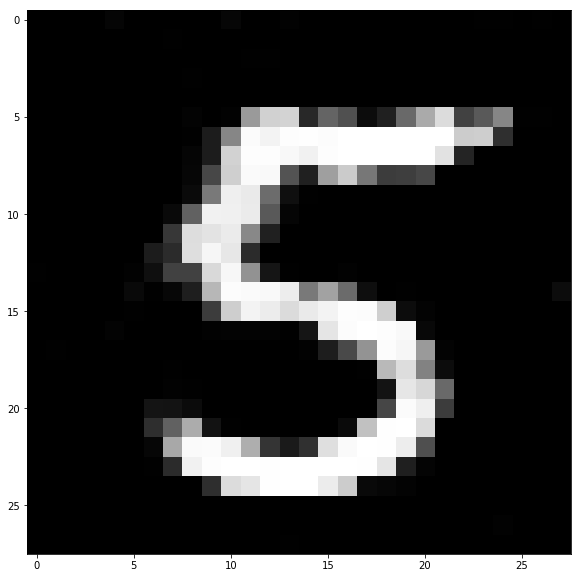

7


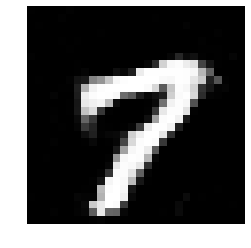

8


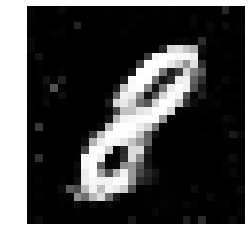

4


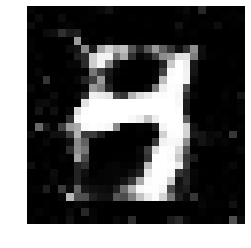

3


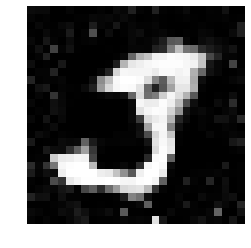

4


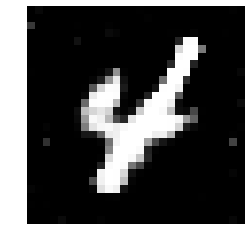

5


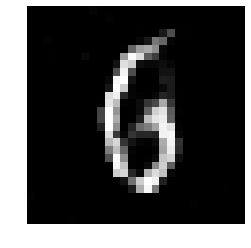

2


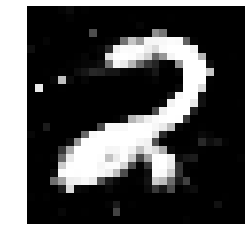

1


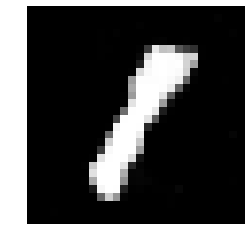

0


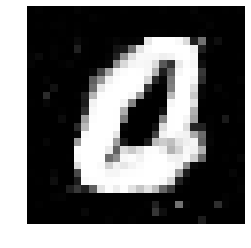

4


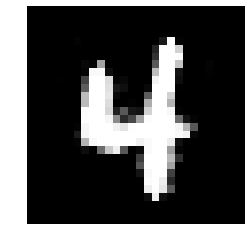

5


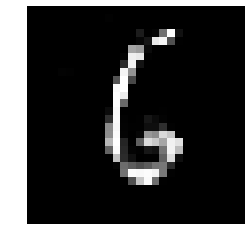

7


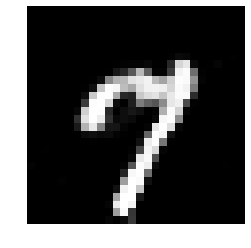

1


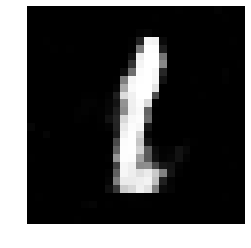

7


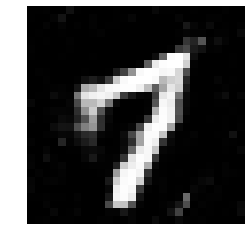

1


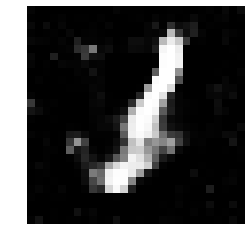

4


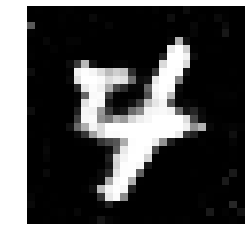

6


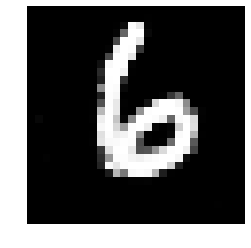

0


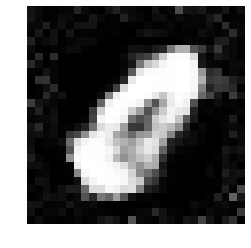

4


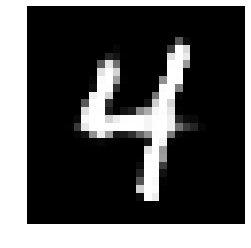

3


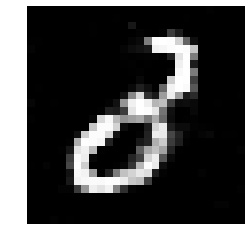

1


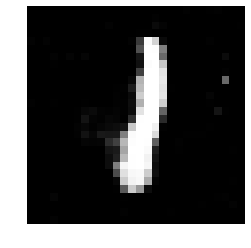

0


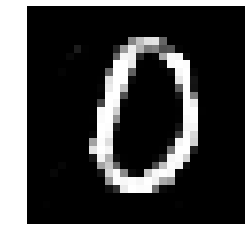

3


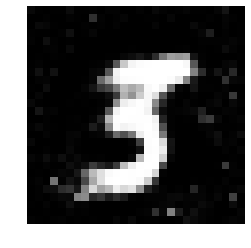

2


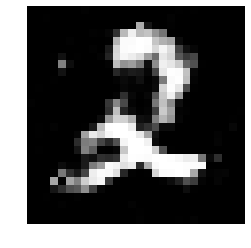

7


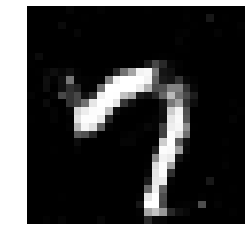

7


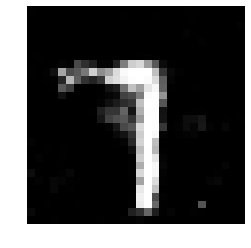

3


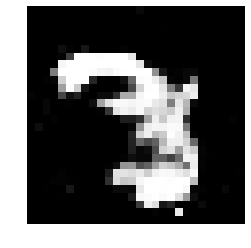

7


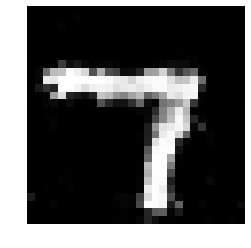

3


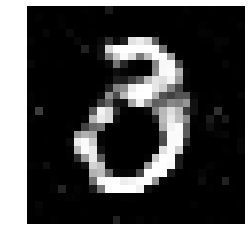

3


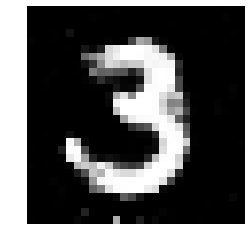

0


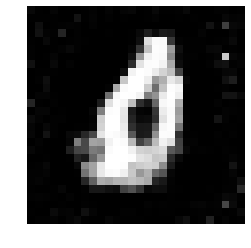

1


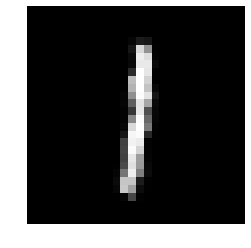

5


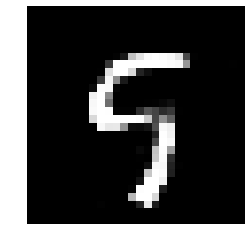

3


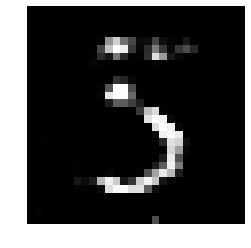

0


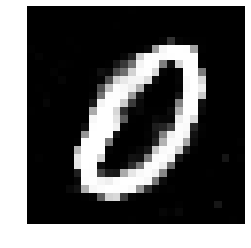

0


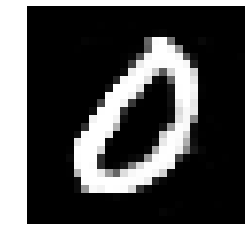

7


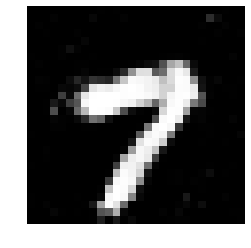

1


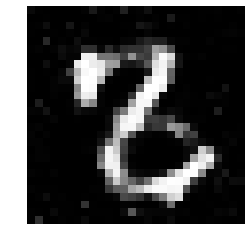

2


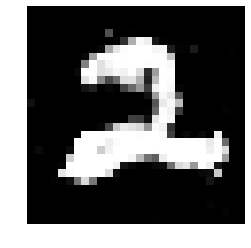

3


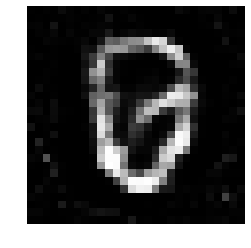

9


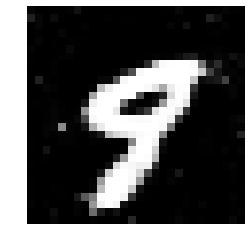

6


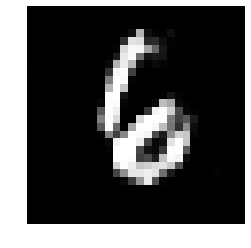

0


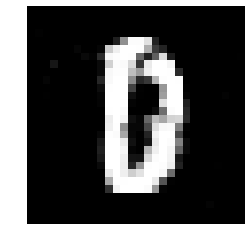

0


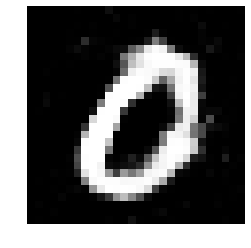

4


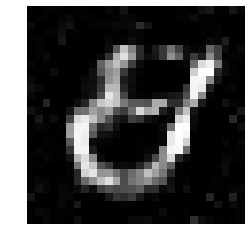

3


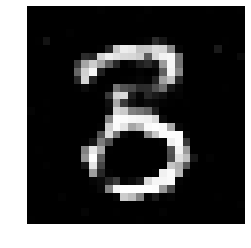

0


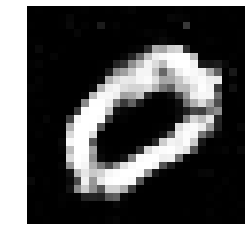

2


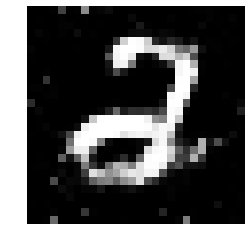

4


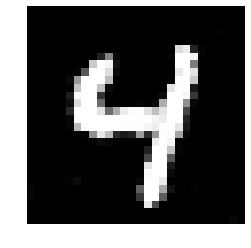

2


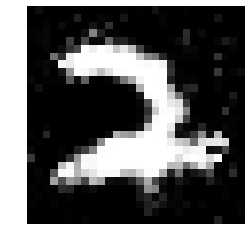

0


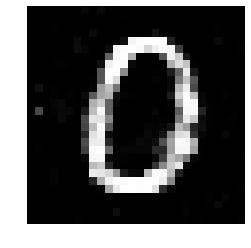

9


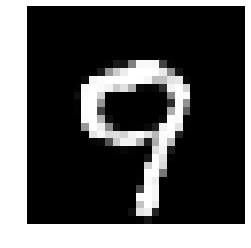

6


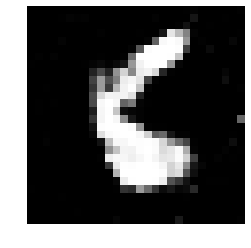

5


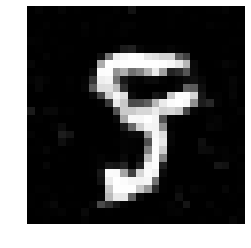

7


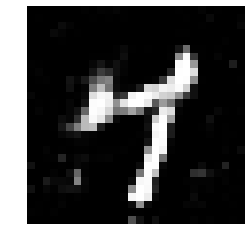

7


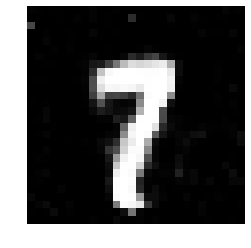

9


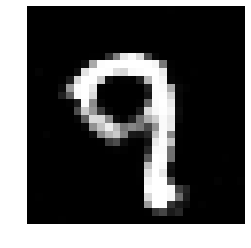

3


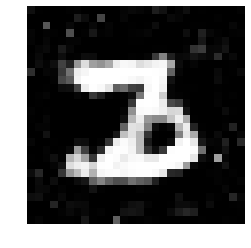

0


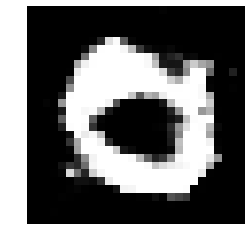

4


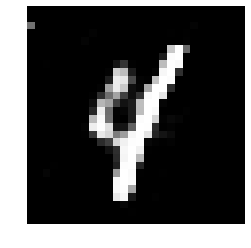

6


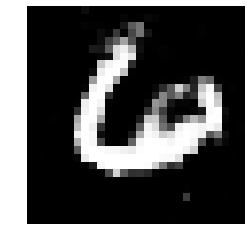

9


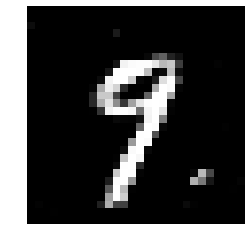

1


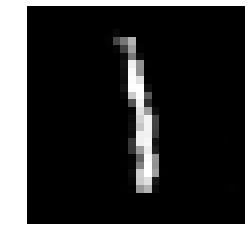

4


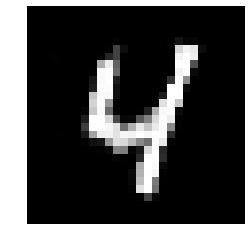

7


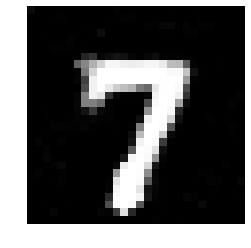

0


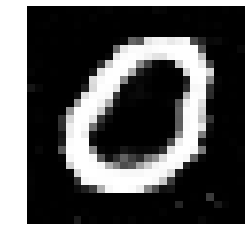

7


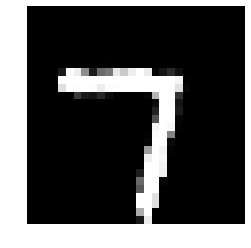

9


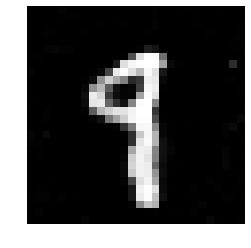

7


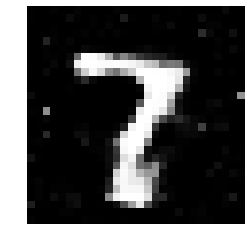

2


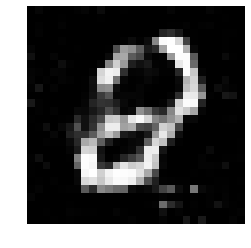

7


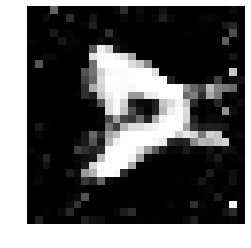

6


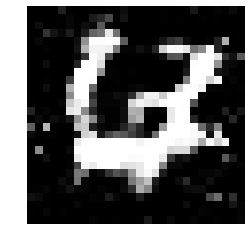

1


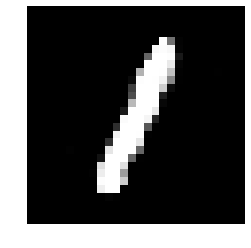

6


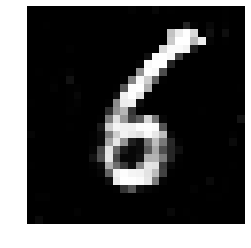

4


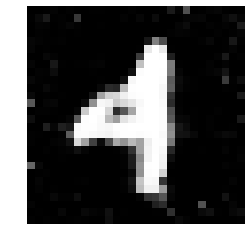

0


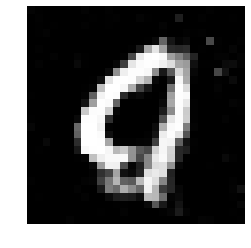

7


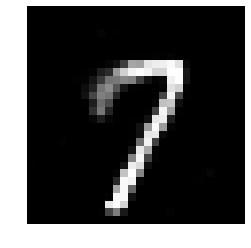

7


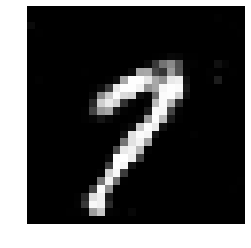

7


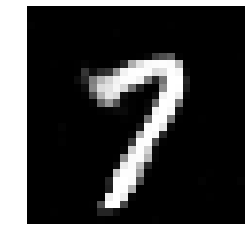

9


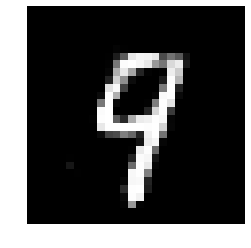

3


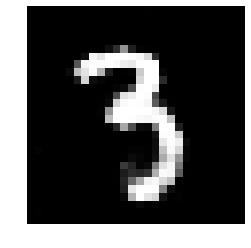

2


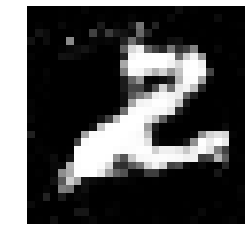

5


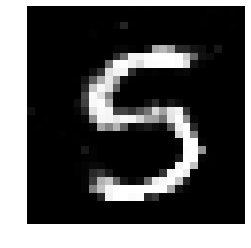

7


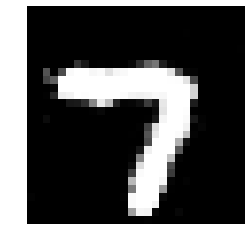

1


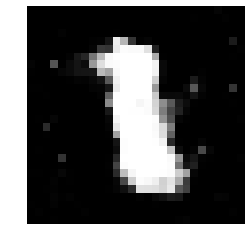

1


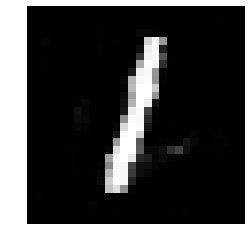

3


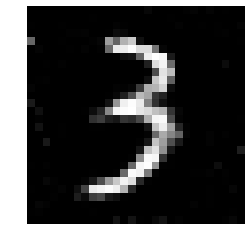

6


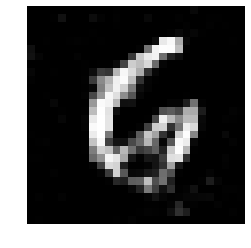

1


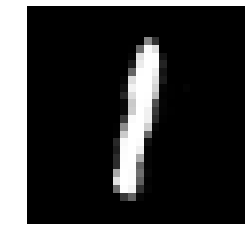

5


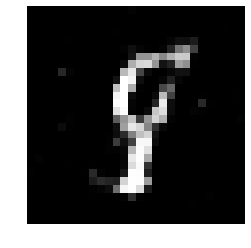

5


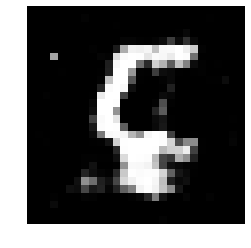

9


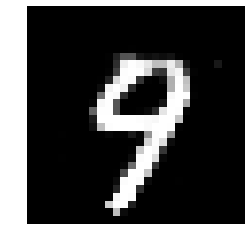

3


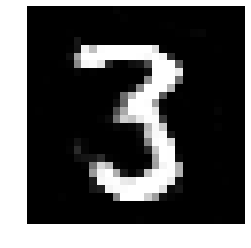

0


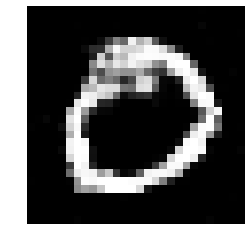

8


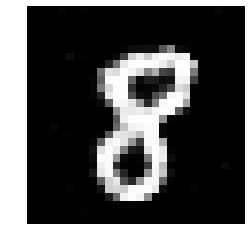

7


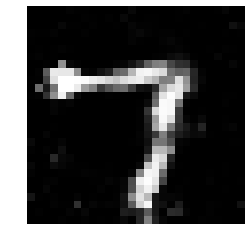

1


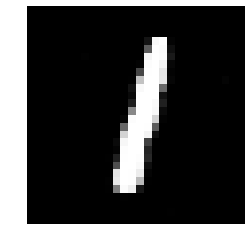

2


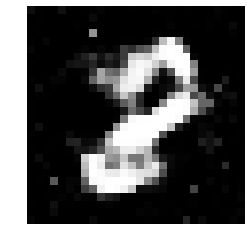

7


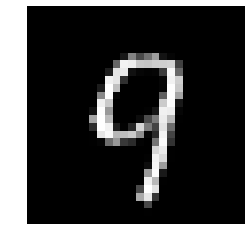

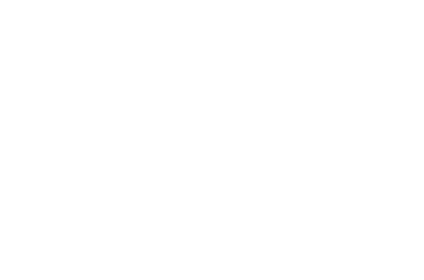

In [0]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 400:
            plot_generated_images(e, generator)           
training(400,128)

In [0]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

(128, 28, 28)
